# Introdução

Este caderno faz as classificações de objetos de licitações entre compras de 'Tecnologia da informação' e 'Outras Compras' usando os modelos GPT3 da OpenAI.

O notebook faz parte de comparações sobre few-shot do GPT3 e do Sentence-Transformers, com o zero-shot do ChatGPT.

Os cadernos e o dataset podem ser encontrados em https://github.com/thacio/Few-Shot-Editais-TI

# Instação das bibliotecas

In [1]:
!pip install openai pandas datasets evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.9/71.9 kB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 22.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 22.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 19.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 15.4 MB/s eta 0:00:00


# Preparação do dataset

Para que os resultados sejam reproduzíveis, os parâmetos de geração do dataset não devem ser alterados (*test_size* para a geração dos datasets do few shot e validação, assim como os *seeds* para obter as amostras.

Os valores foram escolhidos de forma a restar 50 exemplos de cada classe no dataset de treino.


## Download e split no dataset

In [2]:
!wget https://github.com/thacio/Few-Shot-Editais-TI/raw/main/editais_TI.xlsx

--2023-05-09 00:29:12--  https://github.com/thacio/Few-Shot-Editais-TI/raw/main/editais_TI.xlsx
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/thacio/Few-Shot-Editais-TI/main/editais_TI.xlsx [following]
--2023-05-09 00:29:12--  https://raw.githubusercontent.com/thacio/Few-Shot-Editais-TI/main/editais_TI.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 702524 (686K) [application/octet-stream]
Saving to: ‘editais_TI.xlsx’

editais_TI.xlsx     100%[===================>] 686.06K  --.-KB/s    in 0.006s  

2023-05-09 00:29:12 (112 MB/s) - ‘editais_TI.xlsx’ saved [702524/702524]



Carrega o dataset e elimina as linhas duplicadas

In [3]:
import pandas
import numpy

df = pandas.read_excel('editais_TI.xlsx')
df['CLASSE_TI'] = df['CLASSE_TI'].replace({0: 'Outras compras', 1: 'Tecnologia da Informação'})
df['DES_OBJETO'] = df['DES_OBJETO'].str.replace('Objeto: Pregão Eletrônico - ', '').str.strip()
df = df[~df['DES_OBJETO'].duplicated()] # Remove colunas com objeto duplicado
df.head()

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
0,0,153038,12019,O objeto da presente licitação é de empresa pa...,Outras compras
1,1,153054,122019,Registro de Preços para futuras aquisições de ...,Outras compras
2,2,153054,152019,Registro de preços para futuras aquisições de ...,Outras compras
3,3,153054,192019,Contratação de empresa para prestação de servi...,Outras compras
4,4,153054,332019,Registro de preço para futuras aquisições de Ó...,Outras compras


Cria o split de validação e de treino. Para o GPT, não haverá fase de treino e o split de treino será convertido em few-shot no prompt.

In [4]:
import pandas as pd

from sklearn.model_selection import train_test_split
df_train, df_validation = train_test_split(df, test_size=0.9408,random_state=43)

df_validation.loc[df_validation['CLASSE_TI'] == 1]
len(df_validation.loc[df_validation['CLASSE_TI'] == 1])/len(df_validation)

df_train.head()

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
4721,4721,240104,172018,"Aquisição de Licenças de uso de Softwares, gar...",Tecnologia da Informação
3488,3488,160036,112018,Registro de preços para atender as necessidade...,Outras compras
2233,2233,153163,3522018,Registro de Preços para a eventual aquisição d...,Outras compras
5163,5163,253002,182018,Contratação de empresa especializada no fornec...,Tecnologia da Informação
863,863,120195,1652018,Contratação de serviços continuados de limpeza...,Outras compras


## Equilibra as classes no set da instrução e move o restante para a validação

*Este código está sendo executado aqui para fins de reprodução dos datasets*

Como estamos trabalhando com few-shot, todos os excessos de classe do dataset de treinamento (que será transformado em few-shot) será transferido para o dataset de validação, de forma a equilibrar as classes.

In [5]:
import pandas as pd
import numpy as np

# Count the number of 0s and 1s in the 'CLASSE_TI' column of the 'df_train' dataframe
num_0 = df_train['CLASSE_TI'].value_counts()[0]
num_1 = df_train['CLASSE_TI'].value_counts()[1]

# Calculate the difference between the number of 0s and 1s
diff = num_0 - num_1

# If the difference is greater than 0, randomly select that many rows from 'df_train' with label 0 and append them to 'df_validation'
if diff > 0:
    rows_to_move = df_train[df_train['CLASSE_TI'] == 'Outras compras'].sample(n=diff, random_state=42)
    df_validation = pd.concat([df_validation, rows_to_move], ignore_index=True)
    df_train = df_train.drop(rows_to_move.index)

# If the difference is less than 0, randomly select that many rows from 'df_train' with label 1 and append them to 'df_validation'
elif diff < 0:
    rows_to_move = df_train[df_train['CLASSE_TI'] == 'Tecnologia da Informação'].sample(n=-diff, random_state=42)
    df_validation = pd.concat([df_validation, rows_to_move], ignore_index=True)
    df_train = df_train.drop(rows_to_move.index)

# If the difference is already 0, do nothing
else:
    pass

## Estatística do datset

In [6]:
# Get the number of examples in each dataframe
num_train_examples = len(df_train)
num_validation_examples = len(df_validation)

# Get the number of examples in each class for each dataframe
train_class_counts = df_train['CLASSE_TI'].value_counts()
validation_class_counts = df_validation['CLASSE_TI'].value_counts()

# Calculate the percentage of each class for each dataframe
train_class_percents = train_class_counts / num_train_examples * 100
validation_class_percents = validation_class_counts / num_validation_examples * 100

# Calculate the percentage of the validation set compared to the total
validation_percent_total = num_validation_examples / (num_train_examples + num_validation_examples) * 100

# Calculate the ratio of the number of examples in each class between the validation and training sets
class_ratio_0 = validation_class_counts[0] / (train_class_counts[0]+validation_class_counts[0]) * 100
class_ratio_1 = validation_class_counts[1] / (train_class_counts[1]+validation_class_counts[1]) * 100

# Print out the results
print("Training Data Stats:")
print(f"Total examples: {num_train_examples}")
print(f"Class 0 count: {train_class_counts[0]}, Class 0 percent: {train_class_percents[0]:.2f}%")
print(f"Class 1 count: {train_class_counts[1]}, Class 1 percent: {train_class_percents[1]:.2f}%")
print()

print("Validation Data Stats:")
print(f"Total examples: {num_validation_examples}")
print(f"Class 0 count: {validation_class_counts[0]}, Class 0 percent: {validation_class_percents[0]:.2f}%")
print(f"Class 1 count: {validation_class_counts[1]}, Class 1 percent: {validation_class_percents[1]:.2f}%")
print()
print(f"Percentage of validation set compared to total: {validation_percent_total:.2f}%")
print(f"Class 0 ratio (val/total): {class_ratio_0:.2f}%")
print(f"Class 1 ratio (val/total): {class_ratio_1:.2f}%")

Training Data Stats:
Total examples: 100
Class 0 count: 50, Class 0 percent: 50.00%
Class 1 count: 50, Class 1 percent: 50.00%

Validation Data Stats:
Total examples: 6545
Class 0 count: 5629, Class 0 percent: 86.00%
Class 1 count: 916, Class 1 percent: 14.00%

Percentage of validation set compared to total: 98.50%
Class 0 ratio (val/total): 99.12%
Class 1 ratio (val/total): 94.82%


Utilizaremos a biblioteca datasets do huggingface para reprodução do mesmo dataset e comparação com few-shot do SetFit e GPT3 e zero-shot do ChatGPT

In [7]:
import datasets
from datasets import load_dataset

ds_train = datasets.Dataset.from_pandas(df_train)
ds_validation = datasets.Dataset.from_pandas(df_validation)

dataset = datasets.DatasetDict({
    'train' : ds_train,
    'validation' : ds_validation
    })

In [8]:
from datasets import Dataset

# Adaptação de função do setfit para tirar amostras iguais das classes do dataframe
def sample_dataset(dataset: Dataset, label_column: str = "label", num_samples: int = 12, seed: int = 42) -> Dataset:
    """Samples a Dataset to create an equal number of samples per class (when possible)."""
    df = dataset.to_pandas()
    df = df.groupby(label_column)

    # sample num_samples, or at least as much as possible
    df = df.apply(lambda x: x.sample(min(num_samples, len(x)),random_state=seed))
    df = df.reset_index(drop=True)

    all_samples = Dataset.from_pandas(df)
    return all_samples

## Cria o dataset de few-shot

Selecionamos 6 exemplos de cada classe para o few-shot.

Para a validação, selecionaremos 50 exemplos de cada classe, para um total de 100.

In [9]:
few_shot_dataset = sample_dataset(dataset["train"], label_column="CLASSE_TI", num_samples=6,seed=42)
few_shot_dataset = few_shot_dataset.shuffle(seed=42)
eval_dataset = sample_dataset(dataset["validation"], label_column="CLASSE_TI", num_samples=50,seed=42)
eval_dataset = eval_dataset.shuffle(seed=42)

In [10]:
few_shot_dataset_df = few_shot_dataset.to_pandas()
few_shot_dataset_df.to_excel('few_shot_prompt.xlsx', index=False)
print('Dataset do prompt de few-shot')
few_shot_dataset_df

Dataset do prompt de few-shot


,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI,__index_level_0__
0,66,20001,42018,Prestação de serviços de operação e suporte da...,Outras compras,66
1,181,201014,52019,"Aquisição de uma Solução de Gestão Jurídica, c...",Tecnologia da Informação,181
2,4466,200109,82018,Registro de preços para eventual aquisição de ...,Tecnologia da Informação,4466
3,1122,130011,82018,Contratação de serviços continuados de analise...,Tecnologia da Informação,1122
4,5619,323031,342018,Contratação de serviços continuados de apoio t...,Tecnologia da Informação,5619
5,4624,200233,82018,Registro de Preço para aquisição de ESPARGIDOR...,Outras compras,4624
6,3431,160106,572018,Registro de preço para possível aquisição de i...,Outras compras,3431
7,5217,254445,3722018,"Registro de Preços, pelo prazo de até 12 meses...",Outras compras,5217
8,3751,160166,202018,"Contratação de serviços de coleta, transporte,...",Outras compras,3751
9,4992,238014,5982018,Solução comunicação privada e corporativa com ...,Tecnologia da Informação,4992


In [11]:
print('Dataset de validação')
eval_dataset.to_pandas()

Dataset de validação


,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI
0,2105,153164,32018,REGISTRO DE PREÇOS para prestação de serviço d...,Tecnologia da Informação
1,5687,393003,3602018,Contratação de Empresa(s) Especializada(s) par...,Outras compras
2,2150,153173,212018,Contratação de empresa especializada para forn...,Tecnologia da Informação
3,385,50001,1232018,Contratação de empresa especializada na presta...,Outras compras
4,2966,155125,32018,"Aquisição de MEDICAMENTOS GERAIS INJETÁVEIS, p...",Outras compras
...,...,...,...,...,...
95,5179,254420,702018,Aquisição de Cluster Upgrade - Servidor HPE Pr...,Tecnologia da Informação
96,4454,200036,52018,Contratação de empresa especializada para a pr...,Outras compras
97,4751,200100,822018,Registro de Preços para renovação de subscriçã...,Tecnologia da Informação
98,389,50001,1612018,Aquisição de monitores de vídeo.,Tecnologia da Informação


# Configuração da API e função para gerar o prompt

In [12]:
import openai

# Configuração da chave de acesso para a API
openai.api_key_path = './secret.key'
# model_name = "text-ada-001"
# model_name = "text-babbage-001"
# model_name = "text-curie-001"
model_name = "text-davinci-003"

In [13]:
instrucao_inicial = f"""
Vou apresesentar exemplos de objetos de licitação e você classificará o objeto em 'Tecnologia da Informação', caso o objeto se refira a licitação de itens de Tecnologia da informação ou materiais e equipamentos de informática, ou 'Outras compras' para qualquer outro tipo de compra que não seja TI, como escritório, obras, saúde, entre outras.
O último exemplo estará vazio para que você realize a classificação.
Apresente apenas a classificação nessa duas classes, sem qualquer outra palavra adicional.
Exemplos:
"""

# instrucao_inicial = f"""
# Vou apresesentar exemplos de objetos de licitação e você classificará o objeto em 'Tecnologia da Informação', caso o objeto se refira a licitação de itens de Tecnolgoia da informação, ou 'Outras compras', para qualquer outro tipo de compra que não seja TI.
# O último exemplo estará vazio para que você realize a classificação.
# Apresente apenas a classificação nessa duas classes, sem qualquer outra palavra adicional.
# Exemplos:
# """
for i in range(len(few_shot_dataset)):
    instrucao_inicial+= few_shot_dataset[i]['DES_OBJETO'] +' => '+ few_shot_dataset[i]['CLASSE_TI'] + '\n'

print(instrucao_inicial)


Vou apresesentar exemplos de objetos de licitação e você classificará o objeto em 'Tecnologia da Informação', caso o objeto se refira a licitação de itens de Tecnologia da informação ou materiais e equipamentos de informática, ou 'Outras compras' para qualquer outro tipo de compra que não seja TI, como escritório, obras, saúde, entre outras.
O último exemplo estará vazio para que você realize a classificação.
Apresente apenas a classificação nessa duas classes, sem qualquer outra palavra adicional.
Exemplos:
Prestação de serviços de operação e suporte da Central de Atendimento de Telecomunicações do Senado Federal, realizados por equipe técnica residente, nas dependências da Coordenação de Telecomunicações   COOTELE, durante 12 (doze) meses consecutivos, de acordo com as quantidades, periodicidade, especificações, obrigações e demais condições do edital e seus anexos. => Outras compras
Aquisição de uma Solução de Gestão Jurídica, com licenças de uso perpétuo, em conjunto com serviços 

In [14]:
def gerar_parametros_request(instrucao_inicial,exemplo):
    prompt = instrucao_inicial + exemplo['DES_OBJETO']+' => '

    params = {
        "model": model_name,
        "prompt": prompt,
        "temperature": 0.0,
        "max_tokens": 20,
        "n": 1
    }
    return params


# Classificação

Converte o nosso dataset em pandas novamente para salvarmos os resultados e acrescenta a coluna de classificação

In [15]:
# df_few_shot_train = pd.DataFrame(few_shot_dataset)
df_eval = pd.DataFrame(eval_dataset)
df_eval[f'CLASSIFICAÇÃO_{model_name}'] = ''
df_eval

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI,CLASSIFICAÇÃO_text-davinci-003
0,2105,153164,32018,REGISTRO DE PREÇOS para prestação de serviço d...,Tecnologia da Informação,
1,5687,393003,3602018,Contratação de Empresa(s) Especializada(s) par...,Outras compras,
2,2150,153173,212018,Contratação de empresa especializada para forn...,Tecnologia da Informação,
3,385,50001,1232018,Contratação de empresa especializada na presta...,Outras compras,
4,2966,155125,32018,"Aquisição de MEDICAMENTOS GERAIS INJETÁVEIS, p...",Outras compras,
...,...,...,...,...,...,...
95,5179,254420,702018,Aquisição de Cluster Upgrade - Servidor HPE Pr...,Tecnologia da Informação,
96,4454,200036,52018,Contratação de empresa especializada para a pr...,Outras compras,
97,4751,200100,822018,Registro de Preços para renovação de subscriçã...,Tecnologia da Informação,
98,389,50001,1612018,Aquisição de monitores de vídeo.,Tecnologia da Informação,


Classifica usando a API do GPT

In [16]:
classifications = []
for index, row in df_eval.iterrows():
    params = gerar_parametros_request(instrucao_inicial,row)
    # print(params['prompt'])
    response = openai.Completion.create(**params)
    message = response.choices[0].text.strip()
    df_eval.loc[index, f'CLASSIFICAÇÃO_{model_name}']  = message
    # break

df_eval[f'resposta_original_{model_name}'] = df_eval[f'CLASSIFICAÇÃO_{model_name}']
df_eval

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI,CLASSIFICAÇÃO_text-davinci-003,resposta_original_text-davinci-003
0,2105,153164,32018,REGISTRO DE PREÇOS para prestação de serviço d...,Tecnologia da Informação,Tecnologia da Informação,Tecnologia da Informação
1,5687,393003,3602018,Contratação de Empresa(s) Especializada(s) par...,Outras compras,Outras compras,Outras compras
2,2150,153173,212018,Contratação de empresa especializada para forn...,Tecnologia da Informação,Tecnologia da Informação,Tecnologia da Informação
3,385,50001,1232018,Contratação de empresa especializada na presta...,Outras compras,Outras compras,Outras compras
4,2966,155125,32018,"Aquisição de MEDICAMENTOS GERAIS INJETÁVEIS, p...",Outras compras,Outras compras,Outras compras
...,...,...,...,...,...,...,...
95,5179,254420,702018,Aquisição de Cluster Upgrade - Servidor HPE Pr...,Tecnologia da Informação,Tecnologia da Informação,Tecnologia da Informação
96,4454,200036,52018,Contratação de empresa especializada para a pr...,Outras compras,Outras compras,Outras compras
97,4751,200100,822018,Registro de Preços para renovação de subscriçã...,Tecnologia da Informação,Tecnologia da Informação,Tecnologia da Informação
98,389,50001,1612018,Aquisição de monitores de vídeo.,Tecnologia da Informação,Tecnologia da Informação,Tecnologia da Informação


In [18]:
# Vamos corrigir a resposta do GPT caso tenha mandado algum token a mais, como o modelo ada fez
# atribuíremos a primeira classificação que aparecer a resposta
for i in range(len(df_eval)):
    text = str(df_eval.loc[i,f'CLASSIFICAÇÃO_{model_name}'])
    index1 = text.find('Tecnologia da Informação')
    index2 = text.find('Outras compras')

    if index1==-1 and index2==-1:
        df_eval.loc[i,f'CLASSIFICAÇÃO_{model_name}'] = text
    else:
        if index1 == -1:
            first_occurrence = index2
        elif index2 == -1:
            first_occurrence = index1
        else:
            first_occurrence = min(index1, index2)

        # Print the result
        if first_occurrence == index1:
            df_eval.loc[i,f'CLASSIFICAÇÃO_{model_name}'] = 'Tecnologia da informação'
        else:
            df_eval.loc[i,f'CLASSIFICAÇÃO_{model_name}'] = 'Outras compras'

In [19]:
df_eval.to_excel(f'classificados_gpt_{model_name}.xlsx', index=False)

# Calculo das métricas

## Função de cálculo das métricas

In [20]:
import evaluate
from evaluate import load

def calcular_metricas(predictions,labels):
    result = {}

    exact_match_metric = load("accuracy")
    res = exact_match_metric.compute(predictions=predictions,references=labels)
    result.update({'Accuracy': res['accuracy']})

    recall_metric = load('recall')
    res = recall_metric.compute(predictions=predictions,references=labels,pos_label=1)
    result.update({'recall_TI': res['recall']})

    precision_metric = evaluate.load("precision")
    res = precision_metric.compute(predictions=predictions,references=labels,pos_label=1)
    result.update({'precision_TI': res['precision']})

    recall_metric = load('recall')
    res = recall_metric.compute(predictions=predictions,references=labels,pos_label=0)
    result.update({'recall_outros': res['recall']})

    precision_metric = evaluate.load("precision")
    res = precision_metric.compute(predictions=predictions,references=labels,pos_label=0)
    result.update({'precision_outros': res['precision']})

    return result

In [21]:
df_eval.head()

,Unnamed: 0,COD_UASG,NUM_ANO_PREGAO,DES_OBJETO,CLASSE_TI,CLASSIFICAÇÃO_text-davinci-003,resposta_original_text-davinci-003
0,2105,153164,32018,REGISTRO DE PREÇOS para prestação de serviço d...,Tecnologia da Informação,Tecnologia da informação,Tecnologia da Informação
1,5687,393003,3602018,Contratação de Empresa(s) Especializada(s) par...,Outras compras,Outras compras,Outras compras
2,2150,153173,212018,Contratação de empresa especializada para forn...,Tecnologia da Informação,Tecnologia da informação,Tecnologia da Informação
3,385,50001,1232018,Contratação de empresa especializada na presta...,Outras compras,Outras compras,Outras compras
4,2966,155125,32018,"Aquisição de MEDICAMENTOS GERAIS INJETÁVEIS, p...",Outras compras,Outras compras,Outras compras


In [22]:
labels = df_eval['CLASSE_TI'].tolist()
pred = df_eval[f'CLASSIFICAÇÃO_{model_name}'].tolist()

for _list in [labels, pred]:
    for i in range(len(_list)):
        if _list[i]=='Outras compras':
            _list[i] = 0
        else:
            _list[i] = 1

metricas = calcular_metricas(pred,labels)
metricas

{'Accuracy': 0.95,
 'recall_TI': 0.96,
 'precision_TI': 0.9411764705882353,
 'recall_outros': 0.94,
 'precision_outros': 0.9591836734693877}

6 shot
```
Ada
{'Accuracy': 0.55,
 'recall_TI': 0.78,
 'precision_TI': 0.5342465753424658,
 'recall_outros': 0.32,
 'precision_outros': 0.5925925925925926}
```



```
Baggage
{'Accuracy': 0.6,
 'recall_TI': 0.96,
 'precision_TI': 0.5581395348837209,
 'recall_outros': 0.24,
 'precision_outros': 0.8571428571428571}
```

```
Curie
{'Accuracy': 0.55,
 'recall_TI': 0.96,
 'precision_TI': 0.5274725274725275,
 'recall_outros': 0.14,
 'precision_outros': 0.7777777777777778}
```

```
davinci-003
{'Accuracy': 0.95,
 'recall_TI': 0.96,
 'precision_TI': 0.9411764705882353,
 'recall_outros': 0.94,
 'precision_outros': 0.9591836734693877}
```


# Matriz de confusão

Outros Precision: 0.959
Outros Recall: 0.940
Outros F1 Score: 0.949

TI Precision: 0.941
TI Recall: 0.960
TI F1 Score: 0.950



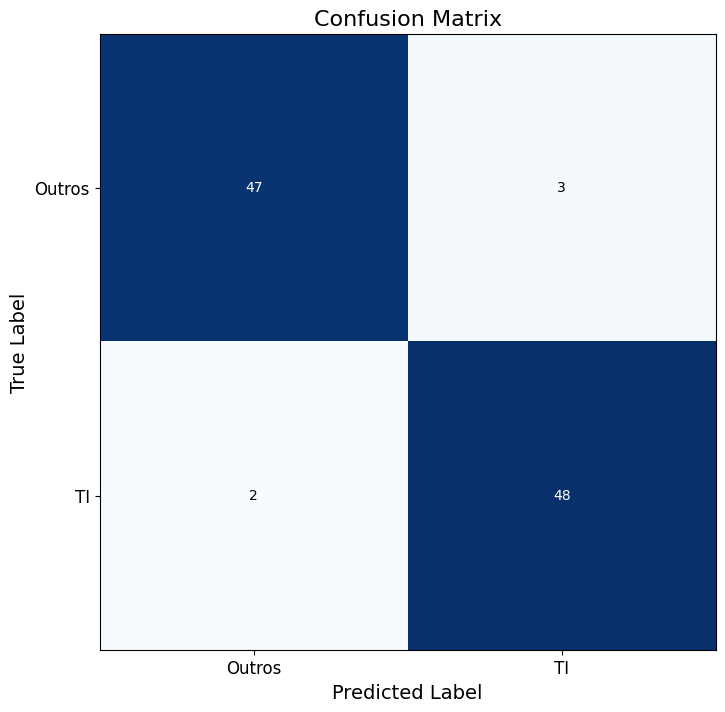

In [23]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score



# Define class labels
class_names = ['Outros', 'TI']

# Define true labels and predicted labels

# Calculate confusion matrix
cm = confusion_matrix(labels, pred)

# Calculate precision, recall, and F1 score for each class
precision = precision_score(labels, pred, average=None)
recall = recall_score(labels, pred, average=None)
f1 = f1_score(labels, pred, average=None)

# Plot confusion matrix
plt.figure(figsize=(8, 8))
plt.imshow(cm, cmap=plt.cm.Blues)
plt.xticks([0, 1], class_names, fontsize=12)
plt.yticks([0, 1], class_names, fontsize=12)
plt.xlabel('Predicted Label', fontsize=14)
plt.ylabel('True Label', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

# Add text annotations for confusion matrix
thresh = cm.max() / 2
for i, j in np.ndindex(cm.shape):
    plt.text(j, i, format(cm[i, j], 'd'), ha='center', va='center',
             color='white' if cm[i, j] > thresh else 'black')

# Print metrics for each class
for i, class_name in enumerate(class_names):
    print(f'{class_name} Precision: {precision[i]:.3f}')
    print(f'{class_name} Recall: {recall[i]:.3f}')
    print(f'{class_name} F1 Score: {f1[i]:.3f}')
    print('')

plt.show()